# Konwolucyjne sieci neuronowe
Autor: Anna Dawid

Korekta: Artur Kalinowski

Rozwiązanie: Zofia Hendrysiak

Dzisiaj poznamy prawdopodobnie najpopularniejszy model sieci neuronowej zaprojektowany do klasyfikacji obrazków wszelkiego rodzaju, a bardziej precyzyjnie: do wszelkich danych, w których istotna jest zależność przestrzenna. Zbudujemy przykładową sieć konwolucyjną (convolutional neural network, CNN), pobawicie się Dropoutem oraz ostatnim sposobem na zwiększanie generalizacji modelu, który poznamy na naszym kursie. Nazywa się on 'data augmentation', polega na generowaniu dodatkowych danych z naszego zestawu danych, bazując na prostych transformacjach - rotacjach, przerzucaniu, podkreślaniu krawędzi, itd. Będziemy znów pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

# Sieci neuronowe ze splotem (konwolucyjne)

Dzisiaj poznamy prawdopodobnie najpopularniejszy model sieci neuronowej zaprojektowany do klasyfikacji obrazków wszelkiego rodzaju, a bardziej precyzyjnie: do wszelkich danych, w których istotna jest zależność przestrzenna. Zbudujemy przykładową sieć ze splotem (convolutional neural network, CNN).

Dodatkowo użyjemy techniki wzbogacania zbioru danych - `data augmentation`
Technika polega na generowaniu dodatkowych danych z istniejącego zestawu, bazując na prostych transformacjach - rotacjach, przerzucaniu, podkreślaniu krawędzi, itd. 

Dziś nadal będziemy pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

## Przygotowanie środowiska programistycznego

By zapewnić powtarzalność wyników ustawiamy ziarno generatora liczb losowych:
```
seed = 128
rng = np.random.RandomState(seed)
```

In [ ]:
import sys, os

from termcolor import colored
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import keras
from keras.datasets import mnist
from keras.utils import np_utils

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf

seed = 128
rng = np.random.RandomState(seed)


def testModelOnMyDigits(model):    
    #Code created by M.Fila
    if not os.path.isdir("colab_freehands"):
        !git clone https://github.com/m-fila/colab_freehands.git

    from colab_freehands.canvas import Canvas  
    canvas = Canvas(line_width=2)
    example = (
        canvas.to_array(size=(20, 20), margin=(4, 4), dtype=np.float32, weighted=True) / 255
    )
    predictions = model(np.expand_dims(example, (0, -1)))
    plt.imshow(example, cmap="gray")
    plt.show()
    print(
        "Predicted class: {} ({:.0f}%)".format(
            np.argmax(predictions), np.max(predictions) * 100
        )
    )

## Import danych MNIST

Proszę:

* wczytać dane korzystając z funkcji ```keras.datasets.mnist.load_data()```
* wypisać na ekran kształ danych uczących i testowych. Ile jest przykładów uczących i testowych? Jaką rozdzielczośc mają analizowane rysunki?
* korzystając z funkcji ```matplotlib.pyplot.imshow()``` narysować przykład numer 0 z danych uczących i wypisać jego etykietę

11501568/11490434 [==============================] - 0s 0us/step
Training data features: (60000, 28, 28)
Training data labels: (60000,)
Test data features: (10000, 28, 28)
Test data labels: (10000,)
Trainig data example number 0: label: 5


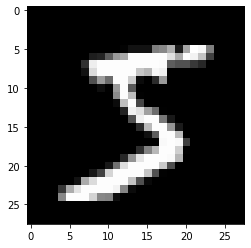

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

print(colored("Training data features:", "blue"), X_train.shape)
print(colored("Training data labels:", "blue"), Y_train.shape)

print(colored("Test data features:", "blue"), X_test.shape)
print(colored("Test data labels:", "blue"), Y_test.shape)


print(colored("Trainig data example number 0:", "blue"), "label:", Y_train[0])
plt.imshow(X_train[0], cmap='gray')

## Wstępne przygotowanie danych (ang. preprocessing)


Sieci ze splotem przyjmują na wejściu kolorowe obrazy. Kształt pojedynczego przykładu to: `(x pixels, y pixels, channels)`, gdzie:
- x, y pixels - liczba pikseli w obu kierunkach
- channels - liczba kolorów, czyli "kanałów"

Dane które analizujemy mają postać dwuwymiarowych macierzy o kształcie `(x pixels, y pixels)`. Proszę:


* zmienić kształ danych wejściowych na `(x pixels, y pixels, channels)`. W naszym przypadku mamy jeden kolor, czyli kanał. 
* wypisać kształ macierzy po spłaszeniu. Czy wymiar jest zgodny z oczekiwaniem?
* znormalizować wartości danych do zakresu **[0,1]** korzystając z funkcji ```numpy.amax(...)```

Oczekiwany rezultat to:

```
Training data shape before reshaping: (60000, 28, 28)
Training data shape after flattening: (60000, 28, 28, 1)
```

**Wskazówka**: Nowy kształ macierzy można uzyskać dodając 1 do starego:
```
X_train.shape+(-1,)
```

In [ ]:
print("Training data shape before reshaping:", X_train.shape)

X_train = X_train.reshape(X_train.shape+(-1,))
X_test = X_test.reshape(X_test.shape+(-1,))

print("Training data shape after reshaping:", X_train.shape)

maxValue = np.amax(X_train)
print("Maximum value in training data:",maxValue)

X_train = X_train/225
X_test = X_test/225

Training data shape before reshaping: (60000, 28, 28)
Training data shape after reshaping: (60000, 28, 28, 1)
Maximum value in training data: 255


## Zmiana reprezentacji etykiet

Etykiety zawierają numer klasy - cyfry. Łatwiejszą do analizy postacią jest reprezentacja za pomocą słowa bitowego o długości równej licznie klas.
W takim słowie wszystkie bity, oprócz jednego - wskazującego na daną klasę mają wartość **0**:

```
Original label encoding: 5 shape: (60000,)
One hot label encoding: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] shape: (60000, 10)

```

Takie kodowanie nazywa się "one hot encoding".

Proszę:

* korzystając z funkcji ```tensorflow.one_hot(...)``` zamienić etykiety na reprezentację "one hot encoding"
* wypisać na ekran orginalne i nowe kodowanie etykiety dla przykładu 0 ze zbioru uczącego

In [ ]:
print("Original label encoding:",Y_train[0], "shape:", Y_train.shape)
depth = 10

Y_train = tf.one_hot(Y_train, depth)
Y_test = tf.one_hot(Y_test, depth)

print("One hot label encoding for training data:",Y_train[0], "shape:", Y_train.shape)
print("One hot label encoding for test data:",Y_test[0], "shape:", Y_test.shape)

Original label encoding: 5 shape: (60000,)
One hot label encoding for training data: tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32) shape: (60000, 10)
One hot label encoding for test data: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32) shape: (10000, 10)


## Stworzenie  architektury sieci konwolucyjnej

W dzisiejszym modelu będziemy używali nowych rodzajów warstw:

* warstwy konwolucyjnej - klasy typu `tf.keras.layers.Conv2D` itd.

Warstwa konwolucyjna dokonuje splotu na danych wejściowych (zielony rysunek) z filtrem (czerwone wartości w żółtym kwadracie).  Jako wynik zwraca nowe dane (różowy rysunek). Żółta macierz przesuwająca się po zielonym obrazku (z czerwonymi elementami, które się nie zmieniają) to filtr lub jądro. 
Przesuwa się on po danych wejściowych w sposób ustalony przez hiperparametry takie jak
- size - rozmiar samego filtra, tutaj: (3,3)
- stride - krok, tutaj gifie = (1,1)
- padding - co zrobić kiedy filtr wykracza poza dane, czyli gdyby w tym przykładzie filtr był 4x4: można ograniczyć ruch tylko do ruchów bez wychodzenia poza ramkę (padding = valid, domyślny), można zrobić ramkę powielającą piksele sąsiadujące (padding = same), można zrobić ramkę z zer, itd.


Wielkości modyfikowane w ramach treningu to wartości wag filtra pozostałe wielkości to hiperparametry.
W sytuacji kiedy kanałów jest więcej niż jeden wartości dla wszystkich kanałów są domyślnie sumowane dla danego piksela. Zwykle każda wartwa splotu zawiera wiele filtrów, czyli wiele wariantów wartości wag.


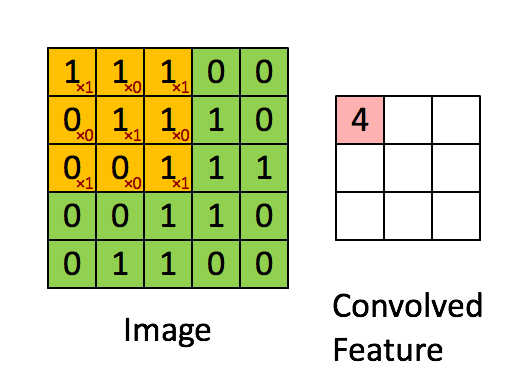

* warstw  łączących  - klasy typu `tf.keras.layers.MaxPooling2D`, `AveragePooling2D` itd.

Warstwa łącząca dokonuje redukcji rozmiaru danych wejściowych (zielony rysunek) z filtrem (fioletowy kwadrat).  Jako wynik zwraca nowe dane (żółty rysunek). Rozmiar filtra i parametry jego ruchu: `size`, `stride` i `padding` są hiperparametrami modelu. Dane pokryte przez filtr są redukowane do
jednej wartości. Najczęściej spotykane algorytmy redukcji to:

* maxpool - wybierany jest element o maksymalnej wartości
* average pool - obliczana jest średnia elementów

W sytuacji, kiedy kanałów jest więcej niż jeden operacja "pooling" jest wykonywana dla każdego kanału oddzielnie.



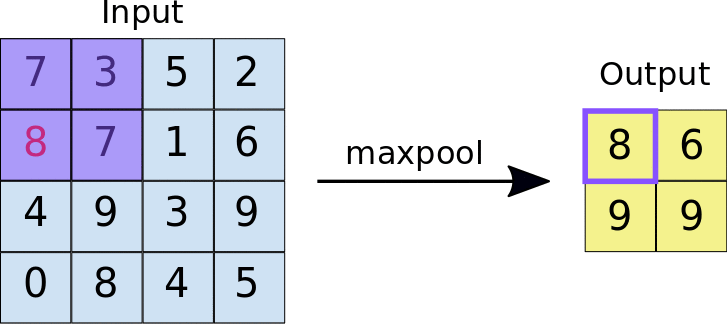

### Definicja architektury sieci ze splotem (CNN)

Proszę zdefiniować sieć neuronową o architekturze w pełni połączonej (ang. fully connected). Sieć powinna mieć:
* warstwę wejściową
* warstwy ukryte złozone z par:
    * warstwa `Conv2D` o parametrach: `filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu`
    * wartwa `MaxPool` o parametrach `pool_size=pool_size`

* warstwę spłaszającą 
* warstwę gęstą o parametrach `nNeurons, activation=tf.nn.relu`
* wartwę wyjściową z funkcją aktywacji ```softmax```  

Proszę:

* dokończyć funkcję ```getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, inputShape, outputWidth)```, która tworzy model o zdefiniowanej powyżej architekturze
* w funkcji skompilowac model, tak by:
    * jako algorytmu minimalizacji używał `adam`
    * jako funkcji straty używał `categorical_crossentropy`
    * jako metryki używał `accuracy`
* obliczyć samodzielnie liczbę parametrów pierwszej warstwy "MaxPool" i porównać ją z wynikiem działania funkcji ```model.summary(...)```
* porównać liczbę parametrów w obecnym modelu i modelu z poprzednich zajęć
* obejrzeć rysunek przedstawiający architekturę modelu, uzyskany przy pomocy funkcji ```tf.keras.utils.plot_model(...)```

Number of parameters for the first maxPool layer: 693962
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-trainable par

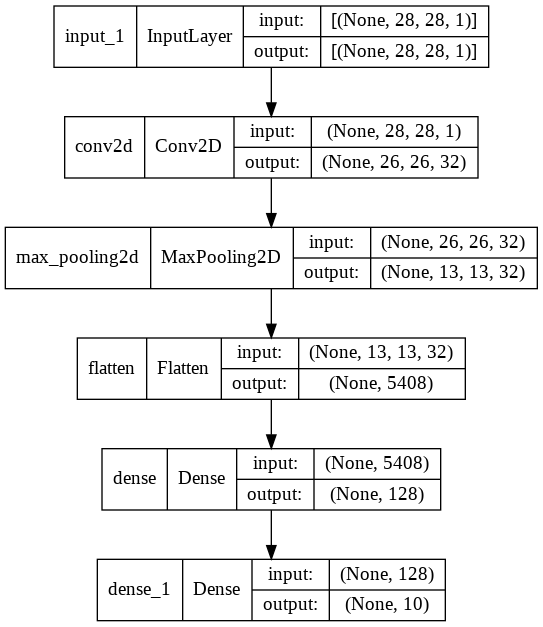

In [ ]:
def getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, inputShape, outputWidth):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=inputShape),
  tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D(pool_size=pool_size),                    
  tf.keras.layers.Flatten(input_shape=inputShape),
  tf.keras.layers.Dense(nNeurons, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )
  return model 

nFilters = 32
kernel_size = 3
pool_size = (2,2)
nNeurons = 128 
nHiddenLayers = 1 
inputShape = (28, 28, 1)
outputWidth = 10

model_basic = getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, inputShape, outputWidth)

print(colored("Number of parameters for the first maxPool layer:","blue"),693962)   

model_basic.summary()
tf.keras.utils.plot_model(model_basic, 'ML_model.png', show_shapes=True)

## Trenowanie modelu

Proszę:

* przeprowadzić trening dla `10` epok z rozmiarem paczki wynoszącym `128`

**Uwaga**: proszę przełączyć środowisko wykonawcze by używało karty graficznej "GPU": z menu na górze:
```
Środowisko wykonawcze -> Zmień typ środowiska wykonawczego
```
Oczekiwany efekt:
```
Epoch 1/15
329/329 [==============================] - 4s 5ms/step - loss: 0.2923 - accuracy: 0.9166 - val_loss: 0.1296 - val_accuracy: 0.9632

Epoch 15/15
329/329 [==============================] - 1s 4ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0650 - val_accuracy: 0.9852
```

Proszę:
* porównać wartości metryki na danych uczących i walidacyjnych. Jaki wniosek wynika z tego porównania?
* porównać metryki obecnego modelu z modelem z siecią gęstą. Jak się sprawuje obecny model? 

**Wskazówka**: w czasie treningu proszę użyć parametru ```validation_split=0.3``` by uzyskać automatyczny podział danych uczących na uczące i walidacyjne.

In [ ]:
%%time 


epochs = 15
batch_size = 128

model_basic_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3)

Epoch 1/15
329/329 [==============================] - 18s 6ms/step - loss: 0.2545 - accuracy: 0.9266 - val_loss: 0.1233 - val_accuracy: 0.9627
Epoch 2/15
329/329 [==============================] - 2s 6ms/step - loss: 0.0826 - accuracy: 0.9757 - val_loss: 0.0802 - val_accuracy: 0.9762
Epoch 3/15
329/329 [==============================] - 2s 6ms/step - loss: 0.0552 - accuracy: 0.9839 - val_loss: 0.0669 - val_accuracy: 0.9796
Epoch 4/15
329/329 [==============================] - 2s 5ms/step - loss: 0.0402 - accuracy: 0.9882 - val_loss: 0.0624 - val_accuracy: 0.9814
Epoch 5/15
329/329 [==============================] - 2s 5ms/step - loss: 0.0295 - accuracy: 0.9918 - val_loss: 0.0683 - val_accuracy: 0.9804
Epoch 6/15
329/329 [==============================] - 2s 6ms/step - loss: 0.0208 - accuracy: 0.9940 - val_loss: 0.0605 - val_accuracy: 0.9832
Epoch 7/15
329/329 [==============================] - 2s 5ms/step - loss: 0.0156 - accuracy: 0.9956 - val_loss: 0.0544 - val_accuracy: 0.9841
Epoch

## Analiza historii treningu

Proszę uzupełnić funkcję ```plotTrainingHistory(model)```, tak by tworzyła wykresy:

* na jednym wykresie wartości metryki w funkcji numeru epoki obliczone dla danych uczących i treningowych
* na drugim wykresie funkcji straty  w zależności od numeru epoki obliczone dla danych uczących i treningowych

Wartości potrzebnych parametrów są dostępne w obiekcie ```Model.history```

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.9266190528869629, 0.9757381081581116, 0.9838809370994568, 0.9881666898727417, 0.9918095469474792, 0.9940476417541504, 0.9955952167510986, 0.9967857003211975, 0.9975476264953613, 0.9980952143669128, 0.9987618923187256, 0.9989285469055176, 0.9990000128746033, 0.9985714554786682, 0.9993333220481873]


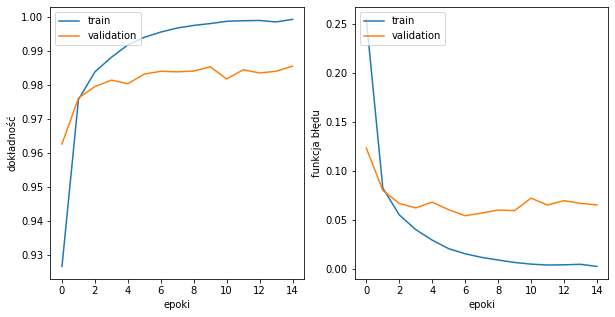

In [ ]:
print(model_basic_fit.history.keys())
history = model_basic_fit.history
print(history['accuracy'])

def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel("dokładność")
    axes[0].set_xlabel("epoki")
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('funkcja błędu')
    axes[1].set_xlabel('epoki')
    axes[1].legend(['train', 'validation'], loc='upper left')
    
    
plotTrainingHistory(model_basic_fit)

## Analiza klasyfikacji

Proszę dokończyć funkcję `printScores(model, X, Y)`, która wypisuje na erkan:
* raport klasyfikacji
* macierz pomyłek

i użyć tej funkcji do wypisania wydajności modelu `model_basic`.

**Wskazówka**: proszę użyć funkcji `printScores(model, X, Y)` zdefiniowanej na innych ćwiczeniach.

**Uwaga**: funkcje typu `sklearn.metrics.classification_report(...)` jako dane wejściowe przyjmują numery klas. Proszę użyć funkcji `numpy.argmax(...)`, by z wektora "one_hot" uzyskać numer klasy o największym pradwopodobieństwie.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def printScores(model, X, Y):
    # użyj classification_report() żeby policzyć najpopularniejsze miary 
    print("Classification report:")
    y_predict = np.argmax(model.predict(X), axis=1)
    print(classification_report(Y, y_predict))
    # wypisz macierz pomyłek 
    print("Confusion matrix:")
    print(confusion_matrix(Y, y_predict))
    
    
printScores(model_basic, X_test, np.argmax(Y_test, axis=1)) 

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion matrix:
[[ 974    0    2    0    0    1    0    1    2    0]
 [   0 1131    2    0    0    0    2    0    0    0]
 [   3    2 1017    2    1    0    0    4    3    0]
 [   0    0    3 1000    0    3    0    0

Cloning into 'colab_freehands'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


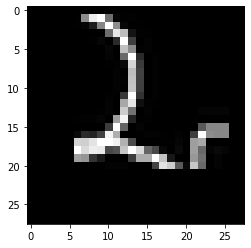

Predicted class: 2 (100%)


In [ ]:
testModelOnMyDigits(model_basic)

## Ilustracja błędnie sklasyfikowanych przykładów.

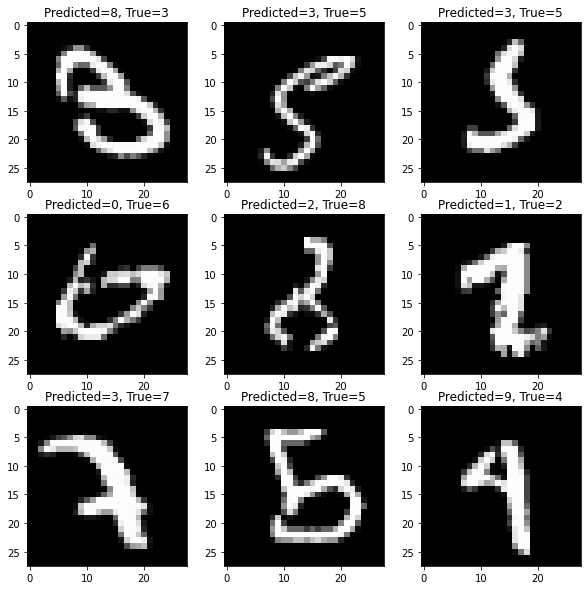

In [ ]:
Y_pred = model_basic.predict(X_test).argmax(axis=1)
missclassified_indices  = Y_pred != np.argmax(Y_test, axis=1)
missclassified_data = X_test[missclassified_indices,:,:,:]
missclassified_labels = tf.boolean_mask(Y_test,missclassified_indices)

def plotExamples(model, data, labels):
    fig, axes= plt.subplots(3,3,figsize=(10,10))
    for k, ax in zip(range(axes.size), axes.reshape(-1)):
        ax.imshow(data[k,:,:,0].reshape(28,28), cmap='gray', interpolation='none')
        Y_pred = model.predict(data[k:k+1,:,:,:])
        Y_pred = np.argmax(Y_pred, axis=1)[0]   
        Y_true = np.argmax(labels[k])              
        ax.set_title("Predicted={}, True={}".format(Y_pred, Y_true))
   

plotExamples(model_basic, missclassified_data, missclassified_labels)

## Model z warstwą "dropout" oraz regularyzacją L2

Proszę:

* napisać funkcję ```getModelWithDropout(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, inputShape, outputWidth)```,
która zawiera warstwę `tf.keras.layers.Dropout()` po warstwie `MaxPool2D`. Dodatkowo parametry modelu powinny mieć regularyzację L2.
* stworzyć nowy model `model_with_reg = getModelWithRegularisation(...)`
* wytrenować model
* wypisać jego metryki i sprawdzić działanie na **tych** samych przykładach, które były błędnie sklasyfikowane przez poprzedni model.

Jak wyglądają krzywe metryk dla zbiorów uczącego i walidacyjnego w funkcji numeru epoki? 

Czy z ich zachowania można wyciągnąć jakiś wniosek odnośnie czasu treningu?

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
Epoch 1/15
329/329 [==============================] - 3s 6ms/step - loss: 0.4426 - accuracy: 0.9192 - val_loss: 0.2770 - val_accuracy: 0.9595
Epoch 2/15
329/329 [==============================] - 2s 5ms/step - loss: 0.2507 - accuracy: 0.9628 - val_loss: 0.2552 - val_accuracy: 0.9570
Epoch 3/15
329/329 [==============================] - 2s 6ms/step - loss: 0.2231 - accuracy: 0.9680 - val_loss: 0.2289 - val_accuracy: 0.9659
Epoch 4/15
329/329 [==============================] - 2s 5ms/step - loss: 0.2100 - accuracy: 0.9715 - val_loss: 0.2150 - val_accuracy: 0.9694
Epoch 5/15
329/329 [==============================] - 2s 6ms/step - loss: 0.2039 - accuracy: 0.9730 - val_loss: 0.2179 - val_accuracy: 0.9689
Epoch 6/15
329/329 [==============================] - 2s 5ms/step - loss: 0.1987 - accuracy: 0.9746 - val_loss: 0.1924 - val_accuracy: 0.9764
Epoch 7/15
329/329 [==============================] - 2s 6ms/step - loss: 0.1928

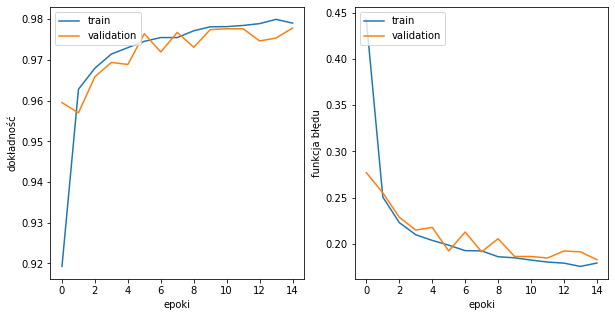

In [ ]:
%time 

def getModelWithRegularisation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=inputShape),
  tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.MaxPooling2D(pool_size=pool_size),           
  tf.keras.layers.Dropout(dropout_rate),       
  tf.keras.layers.Flatten(input_shape=inputShape),
  tf.keras.layers.Dense(nNeurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.Dense(10, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))
  ])
  model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )
  return model 

epochs=15
dropout_rate = 0.2
l2_lambda = 0.001

model_with_reg = getModelWithRegularisation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)

model_with_reg_fit = model_with_reg.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3)
plotTrainingHistory(model_with_reg_fit)

Krzywa dokładności dla danych walidacyjnych nie odbiega od krzywej dla danych treningowych po 15 epokach. To wskazuje, że trening można przedłużyć.
Proszę wytrenować model przez kolejne 20 epok i przeprowadzić na nim sprawdziany jak poprzednio.

In [ ]:
%time
model_with_reg_fit2 = model_with_reg.fit(X_train, Y_train, epochs=20, batch_size=batch_size, validation_split=0.3)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Epoch 1/20
329/329 [==============================] - 2s 7ms/step - loss: 0.1786 - accuracy: 0.9796 - val_loss: 0.1823 - val_accuracy: 0.9779
Epoch 2/20
329/329 [==============================] - 2s 5ms/step - loss: 0.1715 - accuracy: 0.9814 - val_loss: 0.1782 - val_accuracy: 0.9779
Epoch 3/20
329/329 [==============================] - 2s 5ms/step - loss: 0.1736 - accuracy: 0.9804 - val_loss: 0.1778 - val_accuracy: 0.9779
Epoch 4/20
329/329 [==============================] - 2s 6ms/step - loss: 0.1714 - accuracy: 0.9798 - val_loss: 0.1842 - val_accuracy: 0.9759
Epoch 5/20
329/329 [==============================] - 2s 6ms/step - loss: 0.1743 - accuracy: 0.9794 - val_loss: 0.1871 - val_accuracy: 0.9758
Epoch 6/20
329/329 [==============================] - 2s 6ms/step - loss: 0.1710 - accuracy: 0.9801 - val_loss: 0.1728 - val_accuracy: 0.9811
Epoch 7/20
329/329 [==============================] - 2s 6ms/step - loss: 0.1687 - a

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.96      1.00      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion matrix:
[[ 965    0    2    0    1    2    4    0    2    4]
 [   0 1130    2    1    0    1    1    0    0    0]
 [   1    6 1011    1    1    0    0    7    5    0]
 [   1    0    1  983    0   17    0    1

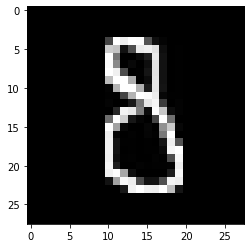

Predicted class: 8 (85%)


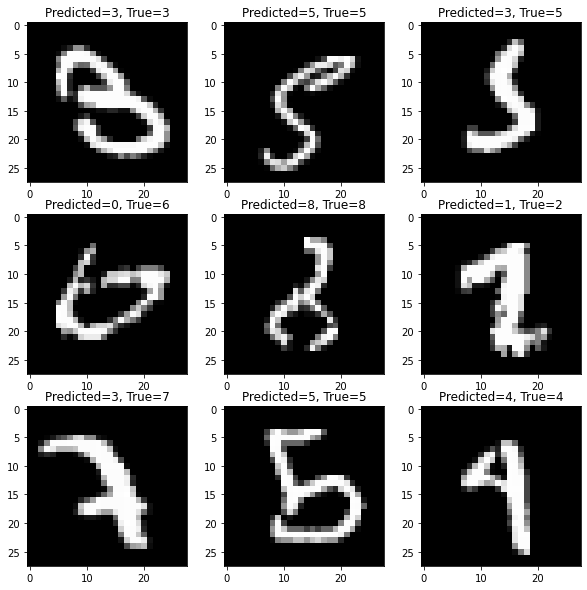

In [ ]:
printScores(model_with_reg, X_test, np.argmax(Y_test, axis=1)) 
testModelOnMyDigits(model_with_reg)
plotExamples(model_with_reg, missclassified_data, missclassified_labels)

## Generacja dodatkowych danych (ang. data augmentation)

Data augmentation polega na generowaniu dodatkowych danych z naszego zestawu danych, bazując na prostych transformacjach - rotacjach, przerzucaniu, podkreślaniu krawędzi, itd. To muszą być transformacje, o których wiemy, że nie powinny wpływać na informacje zawarte w naszych danych. 
Możemy w ten sposób np. nauczyć maszynę, że tożsamość obiektów na rysunkach nie zależy od ich orientacji. 

Dodatkowe dane mogą być uzyskane na różne sposoby. Jednym z nich jest dodanie do modelu warstwy która będzie losowo modyfikowała podany przykład.
Tak warstwa jest aktywna **tylko** w czasie treningu. Lista dostępny modyfikacji w pakiecie TensorFlow jest 
[tutaj](https://www.tensorflow.org/guide/keras/preprocessing_layers).

[Tutaj](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) 
znajdują się przykłady zastosowania różnych transformacji.


Proszę:
* narysować pierwszy przykład ze zbioru uczącego po losowym obrocie w zakresie $\pm$0.05 korzystając z warstwy `tf.keras.layers.RandomRotation()`

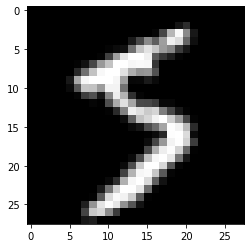

In [ ]:
image = tf.keras.layers.RandomRotation(factor=(-0.05,0.05))(X_train[0])
plt.imshow(image[:,:,0], cmap=plt.get_cmap('gray'));

## Trening z użyciem "data augmentation"

Proszę:

* napisać funkcję, `getModelWithAugmentation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)`,
  która tworzy model z warstwą "data augmentation", oraz pozostałymi warstwami takimi jak tworzone przez funkcję `getModelWithRegularisation(...)`
* stworzyć nowy model `model_with_aug = getModelWithAugmentation(...)`
* wytrenować model
* wypisać jego metryki i sprawdzić działanie na **tych** samych przykładach, które były błędnie sklasyfikowane przez poprzedni model.

A następnie wytrenować model, wypisać jego metryki i sprawdzić działanie na **tych** samych przykładach, które były błędnie sklasyfikowane przez model `model_basic`. 

**Czy zastosowana metoda wzbogacania danych poprawia wydajność modelu?**

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                        

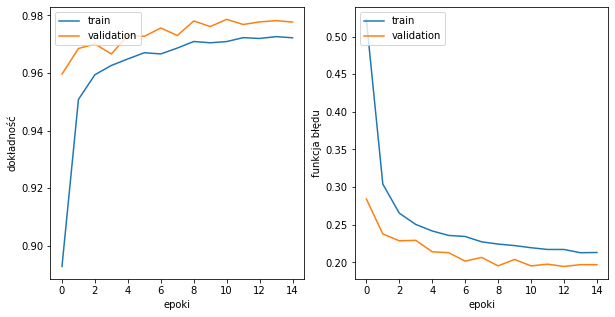

In [ ]:
%time 

def getModelWithAugmentation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=inputShape),
  tf.keras.layers.RandomRotation(factor=(-0.05,0.05)),
  tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.MaxPooling2D(pool_size=pool_size),           
  tf.keras.layers.Dropout(dropout_rate),       
  tf.keras.layers.Flatten(input_shape=inputShape),
  tf.keras.layers.Dense(nNeurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.Dense(10, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))
  ])
  model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )
  return model  

model_with_aug = getModelWithAugmentation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)
model_with_aug.summary()
model_with_aug_fit = model_with_aug.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3)
plotTrainingHistory(model_with_aug_fit)

Techniki przedstawione powyżej dają różne efekty w zależności od zagadnienia. Nie zawsze są one konieczne.

Proszę:

* wskazać model, który będzie miał najmniejszą liczbę błędnie zidentyfikowanych cyfr w zbiorze testowym.

In [ ]:
def misIdCount(model, X, Y):
  Y_pred = model.predict(X_test).argmax(axis=1)
  missclassified_indices  = Y_pred != np.argmax(Y_test, axis=1)
  missclassified_data = X_test[missclassified_indices,:,:,:]
  missclassified_labels = tf.boolean_mask(Y_test,missclassified_indices)
  return len(missclassified_labels)
             

print("Misidentified examples count:")
print(colored("Basic:\t\t","blue"),misIdCount(model_basic, X_test, Y_test))
print(colored("Regularised:\t","blue"),misIdCount(model_with_reg, X_test, Y_test))
print(colored("Augmented:\t","blue"),misIdCount(model_with_aug, X_test, Y_test))
print(colored("Final:\t","blue"),misIdCount(model_final, X_test, Y_test))

Misidentified examples count:
Basic:		 138
Regularised:	 195
Augmented:	 218
Final:	 120


Proszę:

* wytrenować model, który będzie miał mniej niż 100 błędnie zidentyfikowanych przykładów w zbiorze testowym

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_9 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 conv2d_34 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_35 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 10, 10, 32)        9248      
                                                       

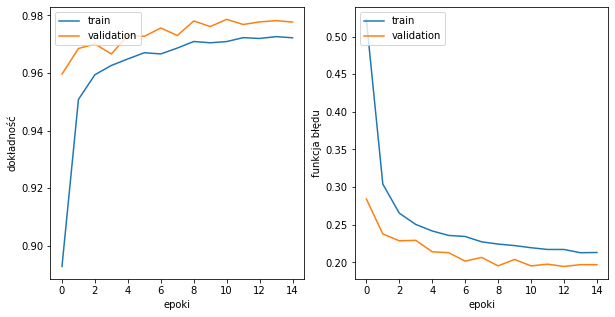

In [ ]:
%time 

def getModelFinal(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=inputShape),
  tf.keras.layers.RandomRotation(factor=(-0.05,0.05)),
  tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.MaxPooling2D(pool_size=pool_size),
  tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.MaxPooling2D(pool_size=pool_size),   
  tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.MaxPooling2D(pool_size=pool_size),             
  tf.keras.layers.Dropout(dropout_rate),       
  tf.keras.layers.Flatten(input_shape=inputShape),
  tf.keras.layers.Dense(nNeurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
  tf.keras.layers.Dropout(dropout_rate),      
  tf.keras.layers.Dense(10, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))
  ])
  model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )
  return model  

model_final = getModelFinal(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)
model_final.summary()
model_final_fit = model_final.fit(X_train, Y_train, epochs=20, batch_size=batch_size, validation_split=0.3)
plotTrainingHistory(model_with_aug_fit)

**Czy postawienie problemu jak w poprzedniej komórce jest prawidłowe?**

Nie - ze względu na losowość rozwiązania oraz doboru próby - w zależności od wybranego ziarna (seed) uczymy się na innych zbiorach. Dlatego możemy przypadkiem trafić na kombinację, która daje wyjątkowo dobre wyniki, choć tak naprawdę sieć nie jest optymalna.